In [2]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [3]:
unitary_param_1 = [0.83414377, 2.27238264, 5.8389326, 2.40918277, 4.47052641, 6.22458201, 1.97847354,
                   1.89334833, 1.88614517, 4.82507852, 2.66745336, 1.38371607, 2.76324645, 3.93540582,
                   0.71193782, 2.74935022]

unitary_param_1 = [3.07688367, 0.9673516, 0.79819022, 2.04583312, 2.85582453, 2.8495334, 5.10685712, 4.90175318, 
                   1.28991267, 6.16482088, 1.86798806, 3.58478087, 2.85012507, 3.6628005, 2.64694583, 0.10050797]

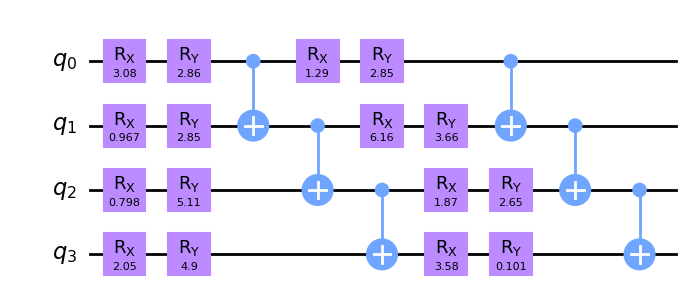

In [4]:
#State \rho_S
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

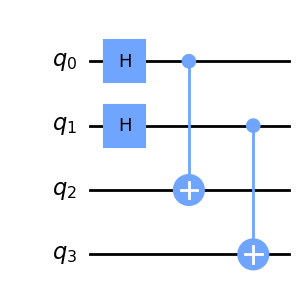

In [26]:
qcTest = QuantumCircuit(4)
qcTest.h(0)
qcTest.cx(0, 2)
qcTest.h(1)
qcTest.cx(1, 3)



qcTest.draw('mpl')

In [27]:
X0   = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])

In [28]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = pt(psi, [3, 4], [2, 2, 2, 2])

In [29]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
sig = cp.Variable(shape, complex=True)
G = cp.bmat([[rho, X.H],[X, sig]])

c = [sig>>0, G>>0, cp.real(cp.trace(sig))==1]

#Add the constraints that make sig G-symmetric
A = np.matmul(X0, SWAP)
B = np.matmul(A, A)
C = np.matmul(A, B)
c.append(A@sig == sig@A)
c.append(B@sig == sig@B)
c.append(C@sig == sig@C)

obj = cp.Maximize(0.5*(cp.real(cp.trace(X)) + cp.real(cp.trace(X.H))))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

Root Fidelity is : 0.9999649729263036


In [30]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.9999299470795031
